In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal
import re

In [2]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

In [4]:
def exp_prob(one_step_prob, n_steps):
    return 1.0 - (1.0 - one_step_prob)**n_steps

In [5]:
class Buffer:
    def __init__(self, nparray, ro=False, dual=False):
        self.ro = ro
        self.dual = dual
        self.host = nparray
        flags = 0
        if ro:
            flags |= mf.READ_ONLY
        else:
            flags |= mf.READ_WRITE
        mkbuf = lambda buf: cl.Buffer(ctx, flags | mf.COPY_HOST_PTR, hostbuf=buf)
        self.buf = mkbuf(self.host)
        if dual:
            self.dbuf = mkbuf(self.host)
    
    def swap(self):
        if self.dual:
            self.buf, self.dbuf = self.dbuf, self.buf
    
    def load(self):
        cl.enqueue_copy(queue, self.host, self.buf)

In [14]:
class World:
    def __init__(self, size, n_agents, param):
        self.size = size
        self.n_agents = (n_agents,)
        self.param = param
        self.step_count = 0
        
        self.w_shape = (size[1], size[0])
        self.a_shape = (n_agents,)
        
        self.buffers = {}
        
        # screen
        self.buffers["w_screen"] = Buffer(np.zeros((*self.w_shape, 3), dtype=np.uint8))
        
        # random
        self.buffers["a_random"] = Buffer(np.random.randint(1<<32, size=self.a_shape, dtype=np.uint32))
        self.buffers["w_random"] = Buffer(np.random.randint(1<<32, size=self.w_shape, dtype=np.uint32))
        
        # world
        self.buffers["w_object_i"] = Buffer(np.zeros((*self.w_shape, 1), dtype=np.int32))
        self.buffers["w_trace_f"] = Buffer(np.zeros((*self.w_shape, 3), dtype=np.float32))
        self.buffers["w_cache_i"] = Buffer(np.zeros((*self.w_shape, 4), dtype=np.int32))
        self.buffers["w_cache_f"] = Buffer(np.zeros((*self.w_shape, 4), dtype=np.float32))
        
        # rnn
        rnn_sx, rnn_sh, rnn_sy = 5, 16, 5
        wxh = 1e-2*np.random.randn(*self.a_shape, (rnn_sx+1)*rnn_sh)
        whh = 1e-2*np.random.randn(*self.a_shape, rnn_sh*rnn_sh)
        why = 1e-2*np.random.randn(*self.a_shape, (rnn_sh+1)*rnn_sy)
        self.buffers["a_rnn_f"] = Buffer(np.concatenate((wxh, whh, why), axis=1).astype(np.float32))
        
        # agents
        a_x = np.random.randint(0, self.size[0], size=self.a_shape)
        a_y = np.random.randint(0, self.size[1], size=self.a_shape)
        a_score = np.zeros(self.a_shape)
        self.buffers["a_agents_i"] = Buffer(np.stack((a_x, a_y, a_score), axis=1).astype(np.int32))
        self.buffers["a_agents_f"] = Buffer(np.zeros((*self.a_shape, rnn_sh), dtype=np.float32))
        
        # parameters        
        self.constants = {
            "WORLD_SIZE_X": self.size[0],
            "WORLD_SIZE_Y": self.size[1],
            "SIZE_A_AGENT_I": self.buffers["a_agents_i"].host.shape[-1],
            "SIZE_A_AGENT_F": self.buffers["a_agents_f"].host.shape[-1],
            "SIZE_W_CACHE_I": self.buffers["w_cache_i"].host.shape[-1],
            "SIZE_W_CACHE_F": self.buffers["w_cache_f"].host.shape[-1],
            "SIZE_W_TRACE_F": self.buffers["w_trace_f"].host.shape[-1],
            "SIZE_W_OBJECT_I": self.buffers["w_object_i"].host.shape[-1],
            "SIZE_A_RNN_F": self.buffers["a_rnn_f"].host.shape[-1],
            "RNN_SIZE_X": rnn_sx,
            "RNN_SIZE_H": rnn_sh,
            "RNN_SIZE_Y": rnn_sy,
        }
        
        self.buffers["PAR_I"] = Buffer(np.array([0], dtype=np.int32), ro=True)
        wperiod = self.param["world_step_period"];
        self.buffers["PAR_F"] = Buffer(np.array([
            exp_prob(self.param["trace_fade_factor"], wperiod),
            exp_prob(self.param["trace_diffusion_factor"], wperiod),
            self.param["trace_animal_factor"],
            exp_prob(self.param["trace_plant_factor"], wperiod),
            exp_prob(self.param["plant_appear_prob"], wperiod),
        ], dtype=np.float32), ro=True)
        
        self.build()
    
    def build(self):
        with open("simple-rnn.cl", "r") as f:
            source = f.read()
            for k, v in self.constants.items():
                source = re.sub("(#define *%s)" % k, "\g<0> %s" % str(v), source)
            self.program = cl.Program(ctx, source).build()
        
    def step(self):
        if (self.step_count % self.param["world_step_period"]) == 0:
            self.program.w_step_read(
                queue,
                self.size,
                None,

                self.buffers["PAR_I"].buf,
                self.buffers["PAR_F"].buf,
                
                self.buffers["w_random"].buf,
                
                self.buffers["w_cache_i"].buf,
                self.buffers["w_cache_f"].buf,

                self.buffers["w_object_i"].buf,
                self.buffers["w_trace_f"].buf,
            )
            
            self.program.w_step_write(
                queue,
                self.size,
                None,

                self.buffers["PAR_I"].buf,
                self.buffers["PAR_F"].buf,
                
                self.buffers["w_random"].buf,
                
                self.buffers["w_cache_i"].buf,
                self.buffers["w_cache_f"].buf,

                self.buffers["w_object_i"].buf,
                self.buffers["w_trace_f"].buf,
            )
        
        self.program.a_step(
            queue,
            self.n_agents,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["a_random"].buf,
            
            self.buffers["a_agents_i"].buf,
            self.buffers["a_agents_f"].buf,
            self.buffers["a_rnn_f"].buf,
            
            self.buffers["w_object_i"].buf,
            self.buffers["w_trace_f"].buf,
        )
        
        self.step_count += 1;
        
    def draw(self):
        self.program.w_draw(
            queue,
            self.size,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["w_object_i"].buf,
            self.buffers["w_trace_f"].buf,
            self.buffers["w_screen"].buf,
        )
        
        self.program.a_draw(
            queue,
            self.n_agents,
            None,
            
            self.buffers["PAR_I"].buf,
            self.buffers["PAR_F"].buf,
            
            self.buffers["a_agents_i"].buf,
            self.buffers["a_agents_f"].buf,
            
            self.buffers["w_screen"].buf,
        )
        self.buffers["w_screen"].load()
        return self.buffers["w_screen"].host

In [20]:
world = World((800, 600), 256, param={
    "world_step_period": 10,
    "plant_appear_prob": 0.0, #1e-7,
    "trace_animal_factor": 0.05,
    "trace_plant_factor": 0.02,
    "trace_fade_factor": 0.0001,
    "trace_diffusion_factor": 0.01,
})

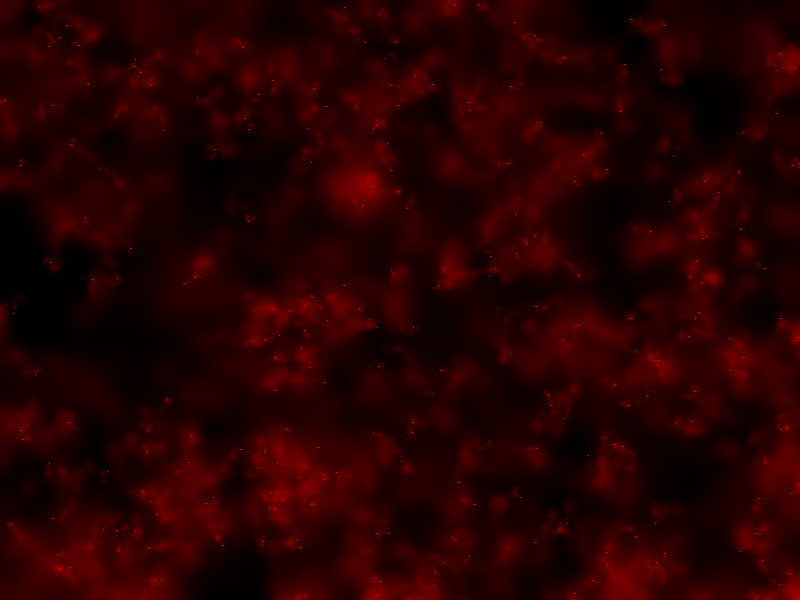

steps elapsed: 14543


In [21]:
stop_on_signal()
last = time.time()
while not signal_done:
    world.step()
    now = time.time()
    if now - last >= 2.0:
        clear_output(wait=True)
        display(Image.fromarray(world.draw()))
        print("steps elapsed: %s" % world.step_count)
        last = now

In [9]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [18]:
params = {
    "-vcodec": "libx264",
    "-pix_fmt": "yuv420p",
    "-profile:v": "baseline",
    "-level": "3"
}
video = FFmpegWriter("tmp.mp4", outputdict=params)
stride = 10
for i in range(10*24):
    for j in range(stride):
        world.step()
    img = world.draw()
    video.writeFrame(img)
video.close()

In [ ]:
with open("tmp.mp4", "rb") as f:
    vdata = f.read()
vbase64 = base64.b64encode(vdata).decode("ascii")
HTML('<video controls src="data:video/mp4;base64,%s" type="video/mp4" >' % vbase64)